In [159]:
# IMPORTS
import glob, os, sys, h5py
import numpy as np
sys.path.insert(0,'../../')
sys.path.insert(0,'/Library/TeX/texbin/')
sys.path.insert(0,'../../WaveformAnalysis')
sys.path.insert(0,'/home/tb829/project/purity-monitor/WaveformAnalysis/')
from scipy.signal import find_peaks, find_peaks_cwt, peak_widths, peak_prominences
from natsort import natsorted
from scipy.optimize import curve_fit
from multiprocessing import Pool, Manager
from ipywidgets import IntProgress
from IPython.display import display
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 100

class Runner:

    def __init__(self):
        return None

    def forrest(self):
        #files = glob.glob(r'/Users/tizi/Documents/YALE_WL.nosync/data/20220812/4Vpp_3min_0.2V_intervals/**/*')
        files = glob.glob(r'/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_3min_0.2V_intervals/10.0kHz/*')

        with Manager() as manager:
            final_dict = manager.dict()
            args = []

            for file in files:
                args.append([file,final_dict])

            pool = Pool()
            pool.starmap(self.magic, args)
            pool.close()

            for key in final_dict.keys():
                print(f'{key} -> {final_dict[key]}')
            return final_dict

    def magic(self, file, final_dict):
        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys(): 
            df = np.array(ch2.get(key))
        h = df
        hx = np.arange(0,len(h),1)
        x,y = hx, h

        voltage = file.split('_')[-2]
        voltage = float(voltage.split('OV')[0])

        frequency = float(file.split('/')[-2].split('kHz')[0])
        print(voltage,' @ ',frequency)
        
        if os.path.exists(f'/home/tb829/data/{voltage}@{frequency}.txt'):
            try: self.load_file(file,final_dict)
            except: pass
            else: return True
            

        pind, pdict = find_peaks(y, prominence=2000)
        print(pind)
        print(pdict)
        mpl.rcParams['figure.dpi']= 200
        plt.plot(x,y)
        plt.show()
        plt.plot(x,y)

        rix_ind = 0
        lix_ind = 0
        rix_ind_ar = x[int(pind):][y[int(pind):] <= pdict['right_bases']]
        if len(rix_ind_ar) == 0: rix_ind = (len(x)-1)
        else: rix_ind = rix_ind_ar[0]
        lix_ind_ar = x[:int(pind)][y[:int(pind)] <= pdict['left_bases']]
        if len(lix_ind_ar) == 0: lix_ind = 0
        else: lix_ind = lix_ind_ar[0]

        plt.vlines(np.asarray([pind,lix_ind,rix_ind]),0,pdict['prominences'].max(),colors=['red'])
        plt.vlines(np.asarray([pdict['left_bases'],pdict['right_bases']]),0,pdict['prominences'].max(),colors=['blue'])
        plt.xlim(lix_ind-10,rix_ind+300)
        plt.show()

        x = x[int(pdict['right_bases']):]
        y = y[int(pdict['right_bases']):]

        plt.plot(x,y)
        plt.show()

        x1, y1 = self.rebin(x,y,100)
        plt.plot(x1,y1)
        plt.show()

        bin_start = 5
        bin_stop = 50
        bin_step = 2 #  DO NOT SET THIS TO FLOAT VALUES --> REBIN ONLY TAKES INTS AND CONVERTS TO INT ANYWAY!!!!!!

        prominence_start = 8
        prominence_stop = 100
        prominence_step = 2

        distance_start = 5
        distance_stop = 50
        distance_step = 2
        #1250/bins

        min_peaks = 5
        max_error = 1.0

        perms = [item for item in itertools.product(np.arange(bin_start, bin_stop,bin_step),np.arange(prominence_start, prominence_stop,prominence_step))]

        f = IntProgress(value=0,min=0,max=len(perms),step=1,description='Loading MCA perms...',bar_style='info',layout={"width": "100%"})
        display(f)

        trials = {}
        for perm in perms:
            f.value += 1
            self.perm_run(perm,x,y,min_peaks,max_error,trials)

        #{'fitted':fitted,'fitted_errs':fitted_errs,'low_comb':lowest_comb,'total_sel':total_selected,'index_sel':index_selected,'gain_sel':gain_selected,'perr_sel':perr_selected,'cumulative':cumulative}
        fits_obtained = {}
        print(trials)
        for p in trials.keys():
            fitted_peaks = trials[p]['fitted']
            fitted_sigmas = trials[p]['fitted_errs']
            lowest_comb_value = trials[p]['low_comb']
            total_selected = trials[p]['total_sel']
            index_selected = trials[p]['index_sel']
            gain_selected = trials[p]['gain_sel']
            sigma_selected = trials[p]['perr_sel']
            cumulative_error = trials[p]['cumulative']

            fit_quality = total_selected/sigma_selected
            fits_obtained[fit_quality] = p

        try:
            best_fit_quality = np.max([*fits_obtained])
            best_fit_perm = fits_obtained[best_fit_quality]
            print(f'Selected {best_fit_perm} for {best_fit_quality} best quality!')
            self.plot_run(best_fit_perm,x,y,min_peaks,max_error,True)
            final_dict[f'{voltage:02f}@{frequency:0.2f}'] = (trials[best_fit_perm]['gain_sel'],trials[best_fit_perm]['perr_sel'])
        except Exception as e:
            if not os.path.exists('./data'): os.mkdir('data')
            with open(f'data/backup_{voltage}@{frequency}.txt','w') as f:
                for k in trials.keys():
                    f.write(f'{k}:{trials[k]}')
                f.close()
        else:
            if not os.path.exists('./data'): os.mkdir('data')
            with open(f'data/{voltage}@{frequency}.txt','w') as f:
                for k in final_dict.keys():
                    f.write(f'{k}:{final_dict[k]}')
                f.close()


    def rebin(self, hx,h,bins):
        bins = int(bins)
        h_rebin=[]
        for i in range(int(len(h)/bins)):
            start_idx=i*bins
            end_idx=(i+1)*bins
            h_rebin.append(np.sum(h[start_idx:end_idx]))
        hx_rebin=range(len(h_rebin))
        return np.array(hx_rebin), np.array(h_rebin)

    def gauss(self, x,a,mu,sigma): return (a*np.exp(-0.5*((x-mu)/sigma)**2))

    def line(self, x,a,b): return a*(x-b)
    
    def load_file(self, file, final_dict):
        print(f'Loading {file}')
        frequencies = {}

        if not 'backup' in f:
            filename = os.path.split(f)[1]
            voltage = float(filename.split('@')[0])
            frequency = float(filename.split('@')[1].split('.')[0])

            with open(f,'r') as opened:
                lines = opened.read().split(')')
                for line in lines:
                    if len(line) == 0: continue
                    key = line.split(':(')[0]
                    value = line.split(':(')[1]
                    voltage = float(key.split('@')[0])
                    frequency = float(key.split('@')[1].split('.txt')[0])
                    if frequency == 0.00:
                        print(filename)
                        print(line)
                    gain = float(value.split(',')[0])
                    error = float(value.split(',')[1])
                    final_dict[f'{voltage:02f}@{freq:0.2f}'] = (gain,error)
                    if not frequency in list(frequencies.keys()): frequencies[frequency] = []
                    frequencies[frequency].append((voltage, (gain,error)))

                    #plt.scatter([voltage],[gain],30,c='red',marker='*')
        #plt.clf()


    def perm_run(self, p,x,y,min_peaks,max_error,trials, plot=True): # False if it fails, 
    
        best_index = None
        
        bins = p[0]
        prominence = p[1]
        distance = 500/bins

        try:
            x1, y1 = self.rebin(x,y,bins)

            pks, pdict = find_peaks(y1,prominence=prominence,distance=distance)

            if len(pks) < min_peaks or len(pks) == 0: return False

            if plot: plt.scatter([pks],[y1[pks]],20,'red','*')

            x2 = np.flip(x1)
            y2 = np.flip(y1)
            flat_end = np.argwhere(y2 > 2)[0][0]
            x2 = x2[flat_end:]
            y2 = y2[flat_end:]
            x1 = np.flip(x2)
            y1 = np.flip(y2)

            if plot: plt.plot(x1,y1)
            plt.show()

            cumulative = 0
            fitted = []
            fitted_errs = []

            for ii in np.arange(0,len(pks),1):
                tolerance = 0.2
                y_cut = y1

                while len(find_peaks(y_cut,prominence=prominence,distance=distance)[0]) > 1 and tolerance < 0.8:
                    index = pks[ii]

                    peak_lx, peak_rx = None, None
                    try: peak_lx = int(index - np.argwhere(np.flip(y1[:index]) < tolerance*y1[index])[0][0]*1.1)
                    except: peak_lx = pdict['left_bases'][ii]
                    try: peak_rx = int((index + np.argwhere(y1[index:] < tolerance*y1[index])[0][0])*1.1)
                    except: peak_rx = pdict['right_bases'][ii]

                    x_cut = x1[int(peak_lx):peak_rx]
                    y_cut = y1[int(peak_lx):peak_rx]

                    if len(find_peaks(y_cut,prominence=prominence)[0]) > 1: tolerance += 0.05

                if np.abs(np.abs(index-peak_lx) - np.abs(peak_rx-index)) > np.abs(index-peak_lx)*0.2:
                    peak_rx = index + np.abs(index-peak_lx)
                    x_cut = x1[int(peak_lx):peak_rx]
                    y_cut = y1[int(peak_lx):peak_rx]

                try: sigma = np.abs(int(index - np.argwhere(np.flip(y1[:index]) < 0.5*y1[index])[0][0]))
                except: sigma = np.abs(index-peak_lx)

                try:popt, pcov = curve_fit(self.gauss,x_cut,y_cut,p0=[y1[index],np.abs(index-peak_lx),sigma],maxfev=10000000)
                except Exception as e: continue
                
                perr = np.sqrt(np.diag(pcov))[1]
                if perr > max_error: continue       # will skip this peak fit due to the error being too large
                cumulative += perr

                fitted.append(popt[1])
                fitted_errs.append(perr)
                cumulative += perr

            cumulative = cumulative/len(pks)

            lowest_comb = 1000
            popt, pcov, perr = None, None, None
            total_selected = None
            index_selected = None
            gain_selected = None
            perr_selected = None

            for ii in np.arange(len(fitted),min_peaks-1,-1):
                for yy in np.arange(0,len(fitted)-ii+1,1):
                    peaks = np.asarray(fitted[yy:yy+ii])*bins
                    perrs = np.asarray(fitted_errs[yy:yy+ii])*bins

                    try: popt,pcov = curve_fit(self.line,np.arange(1,len(peaks)+1),peaks,maxfev=100000,sigma=perrs)
                    except: continue
                    perr = np.sqrt(np.diag(pcov))[1]
                    comb = perr/ii
                    if comb < lowest_comb:
                        lowest_comb = comb
                        total_selected = ii
                        index_selected = yy
                        gain_selected = popt[0]
                        perr_selected = perr
            if total_selected is None: return False

            trials[p] = {'fitted':fitted,'fitted_errs':fitted_errs,'low_comb':lowest_comb,'total_sel':total_selected,'index_sel':index_selected,'gain_sel':gain_selected,'perr_sel':perr_selected,'cumulative':cumulative}

        except Exception as e:
            print(e)
            return False

    def plot_run(self, p,x,y,min_peaks,max_error, plot=True): # False if it fails, 
    
        bins = p[0]
        prominence = p[1]
        distance = 500/bins

        try:
            x1, y1 = self.rebin(x,y,bins)

            pks, pdict = find_peaks(y1,prominence=prominence,distance=distance)

            if len(pks) < min_peaks or len(pks) == 0: return False

            if plot: plt.scatter([pks],[y1[pks]],20,'red','*')

            x2 = np.flip(x1)
            y2 = np.flip(y1)
            flat_end = np.argwhere(y2 > 2)[0][0]
            x2 = x2[flat_end:]
            y2 = y2[flat_end:]
            x1 = np.flip(x2)
            y1 = np.flip(y2)

            plt.subplot(1,2,1)
            plt.plot(x1,y1)
            #plt.show()

            cumulative = 0
            fitted = []
            fitted_errs = []

            for ii in np.arange(0,len(pks),1):
                tolerance = 0.2
                y_cut = y1

                while len(find_peaks(y_cut,prominence=prominence,distance=distance)[0]) > 1 and tolerance < 0.8:
                    index = pks[ii]

                    peak_lx, peak_rx = None, None
                    try: peak_lx = int(index - np.argwhere(np.flip(y1[:index]) < tolerance*y1[index])[0][0]*1.1)
                    except: peak_lx = pdict['left_bases'][ii]
                    try: peak_rx = int((index + np.argwhere(y1[index:] < tolerance*y1[index])[0][0])*1.1)
                    except: peak_rx = pdict['right_bases'][ii]

                    x_cut = x1[int(peak_lx):peak_rx]
                    y_cut = y1[int(peak_lx):peak_rx]

                    if len(find_peaks(y_cut,prominence=prominence)[0]) > 1: tolerance += 0.05

                if np.abs(np.abs(index-peak_lx) - np.abs(peak_rx-index)) > np.abs(index-peak_lx)*0.2:
                    peak_rx = index + np.abs(index-peak_lx)
                    x_cut = x1[int(peak_lx):peak_rx]
                    y_cut = y1[int(peak_lx):peak_rx]

                try: sigma = np.abs(int(index - np.argwhere(np.flip(y1[:index]) < 0.5*y1[index])[0][0]))
                except: sigma = np.abs(index-peak_lx)

                try:popt, pcov = curve_fit(self.gauss,x_cut,y_cut,p0=[y1[index],np.abs(index-peak_lx),sigma],maxfev=10000000)
                except Exception as e: continue
                
                perr = np.sqrt(np.diag(pcov))[1]
                if perr > max_error:       # will skip this peak fit due to the error being too large
                    plt.plot(x1[peak_lx:peak_rx],self.gauss(x1[peak_lx:peak_rx],*popt),color='red')
                    plt.vlines(fitted,0,50,colors=['blue'],linestyles='dotted')
                    plt.scatter([pks[ii]],[y1[pks[ii]]],30,'magenta','*')
                else:
                    plt.plot(x1[peak_lx:peak_rx],self.gauss(x1[peak_lx:peak_rx],*popt),color='lime')
                    plt.vlines(fitted,0,50,colors=['blue'],linestyles='dotted')
                    plt.scatter([pks[ii]],[y1[pks[ii]]],30,'red','*')

                fitted.append(popt[1])
                fitted_errs.append(perr)
                cumulative += perr

            cumulative = cumulative/len(pks)

            plt.subplot(1,2,2)
            lowest_comb = 1000
            popt, pcov, perr = None, None, None
            total_selected = None
            index_selected = None
            gain_selected = None
            perr_selected = None

            for ii in np.arange(len(fitted),min_peaks-1,-1):
                for yy in np.arange(0,len(fitted)-ii+1,1):
                    peaks = np.asarray(fitted[yy:yy+ii])*bins
                    perrs = np.asarray(fitted_errs[yy:yy+ii])*bins
                    x_data = np.arange(1,len(peaks)+1)

                    try: popt,pcov = curve_fit(self.line,x_data,peaks,maxfev=100000,sigma=perrs)
                    except: continue
                    perr = np.sqrt(np.diag(pcov))[1]
                    comb = perr/ii
                    if comb < lowest_comb:
                        lowest_comb = comb
                        total_selected = ii
                        index_selected = yy
                        gain_selected = popt[0]
                        perr_selected = perr
            if total_selected is None: raise Exception()

            peaks = np.asarray(fitted[index_selected:index_selected+total_selected])
            perrs = np.asarray(fitted_errs[index_selected:index_selected+total_selected])
            x_data = np.arange(1,len(peaks)+1)
            popt,pcov = curve_fit(self.line,x_data,peaks,maxfev=100000,sigma=perrs)
            perr = np.sqrt(np.diag(pcov))[1]
            plt.scatter(x_data, peaks,30,'slateblue')
            plt.plot(x_data,self.line(x_data,*popt),'--',label=f'Gain {popt[0]:0.2f} $\pm$ {perr}')
            plt.suptitle(f'Gain {popt[0]:0.2f} $\pm$ {perr}')

        except Exception as e:
            print(e)
            plt.clf()
            return False
        plt.show()

32.4  @  10.0
31.4Loading /gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_3min_0.2V_intervals/10.0kHz/mca_keith_32.40OV_0.h5
34.033.6  @ 30.2    @   @  31.810.0   @ 10.0
32.2 
10.0Loading /gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_3min_0.2V_intervals/10.0kHz/mca_keith_33.60OV_0.h5 @  32.0
  @ Loading /gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_3min_0.2V_intervals/10.0kHz/mca_keith_34.00OV_0.h510.0 
10.0
Loading /gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_3min_0.2V_intervals/10.0kHz/mca_keith_31.80OV_0.h5
 Loading /gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_3min_0.2V_intervals/10.0kHz/mca_keith_32.20OV_0.h531.0 @ 
 31.610.0 
10.0Loading /gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_3min_0.2V_intervals/10.0kHz/mca_keith_31.40OV_0.h5
 @ 
 Loading /gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_3min_0.2V_interval

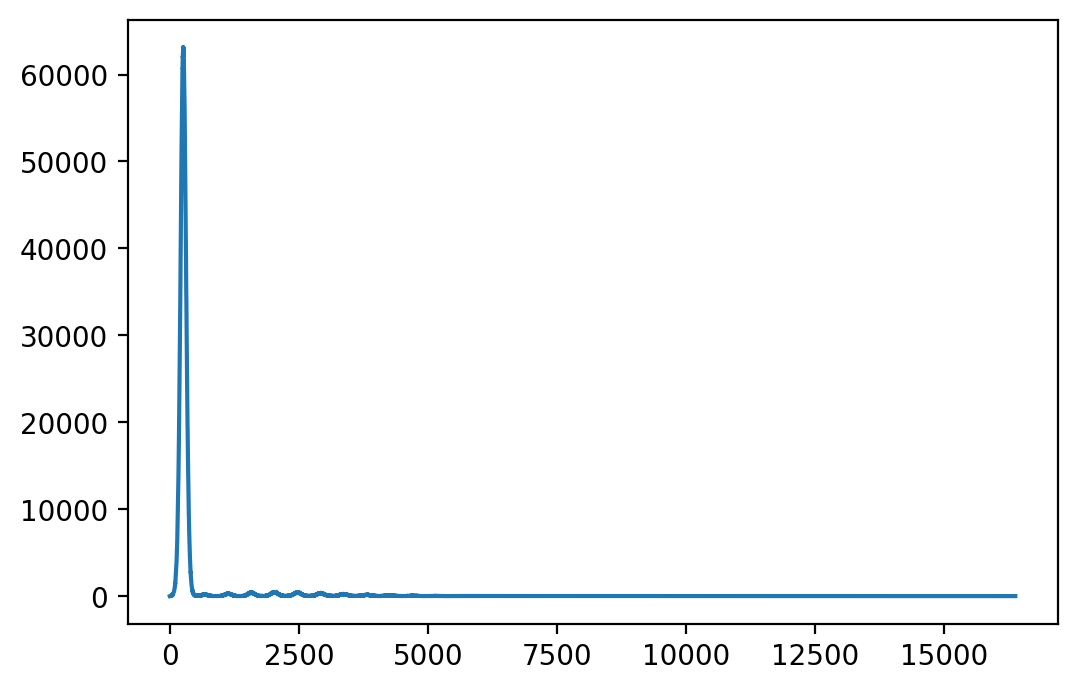

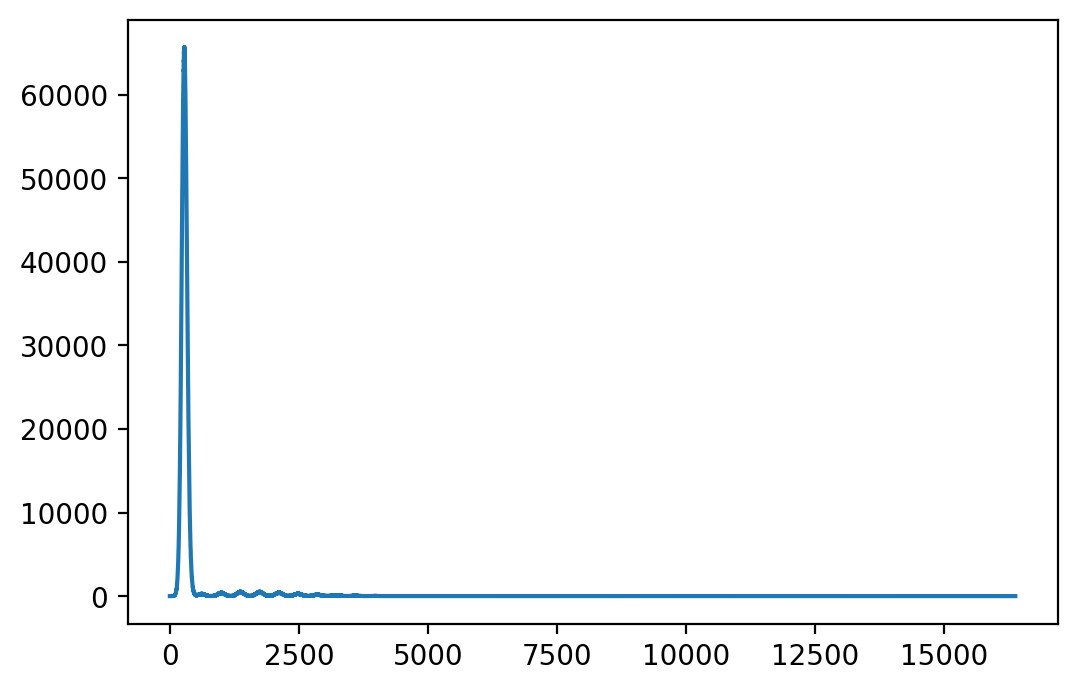

/tmp/ipykernel_3738/611600907.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.vlines(np.asarray([pind,lix_ind,rix_ind]),0,pdict['prominences'].max(),colors=['red'])
/tmp/ipykernel_3738/611600907.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.vlines(np.asarray([pind,lix_ind,rix_ind]),0,pdict['prominences'].max(),colors=['red'])


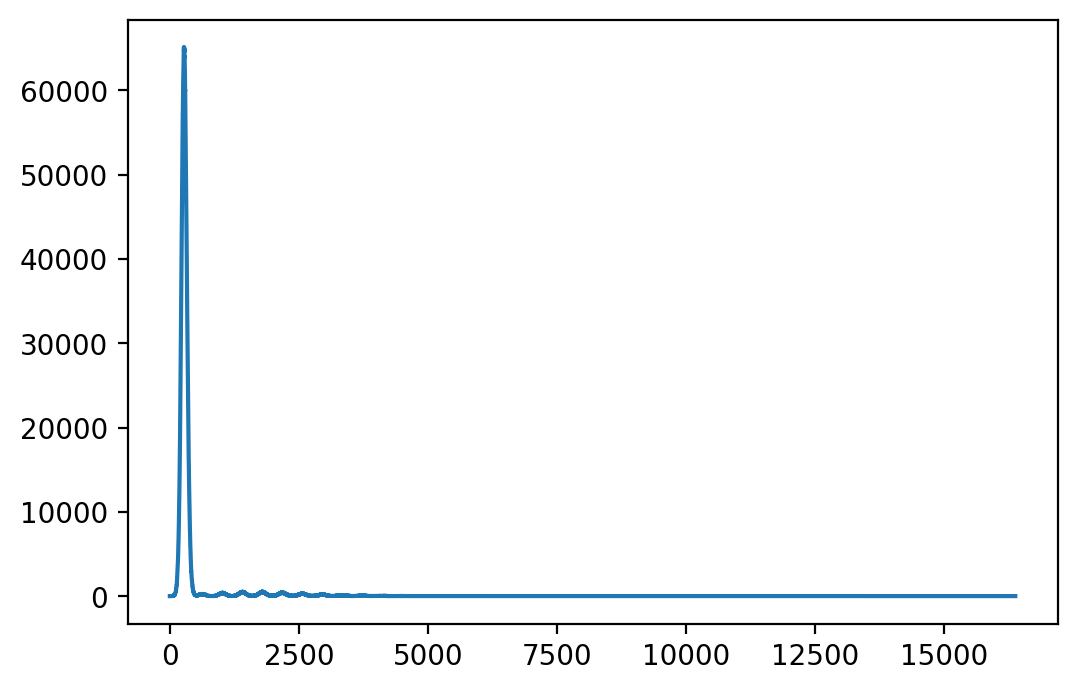

/tmp/ipykernel_3738/611600907.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.vlines(np.asarray([pind,lix_ind,rix_ind]),0,pdict['prominences'].max(),colors=['red'])


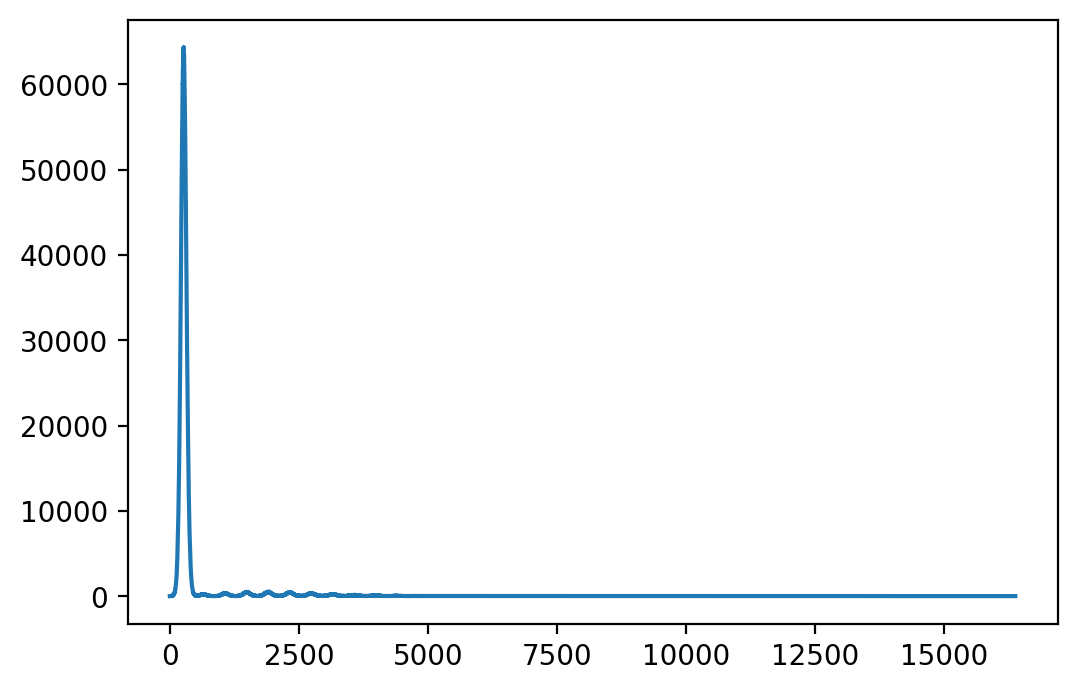

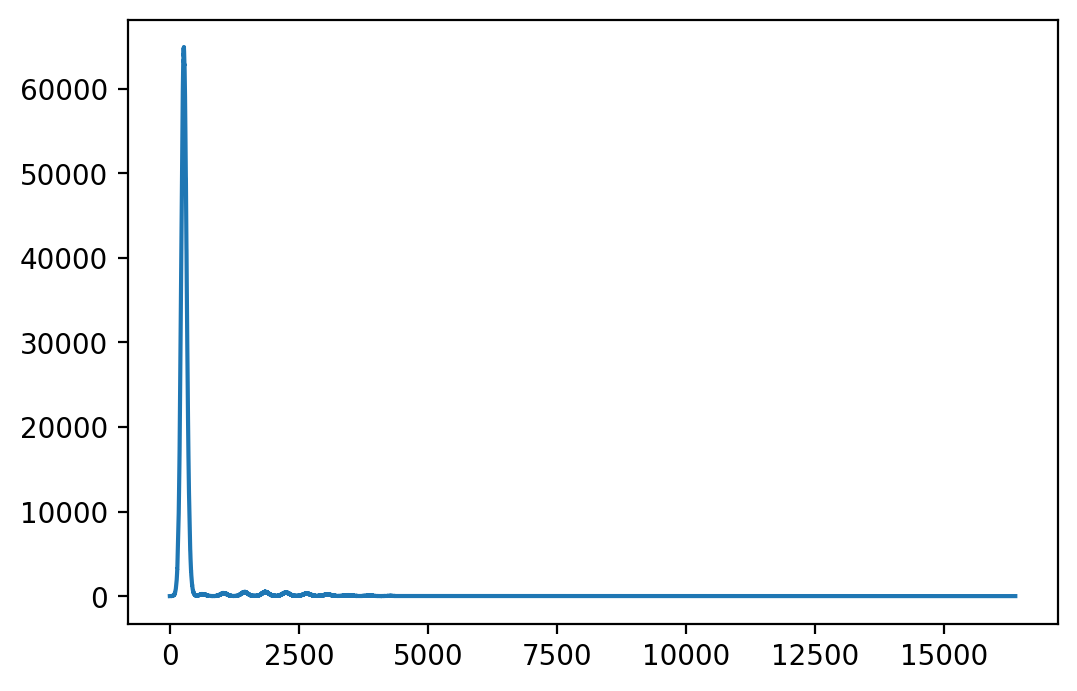

/tmp/ipykernel_3738/611600907.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.vlines(np.asarray([pind,lix_ind,rix_ind]),0,pdict['prominences'].max(),colors=['red'])
/tmp/ipykernel_3738/611600907.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.vlines(np.asarray([pind,lix_ind,rix_ind]),0,pdict['prominences'].max(),colors=['red'])


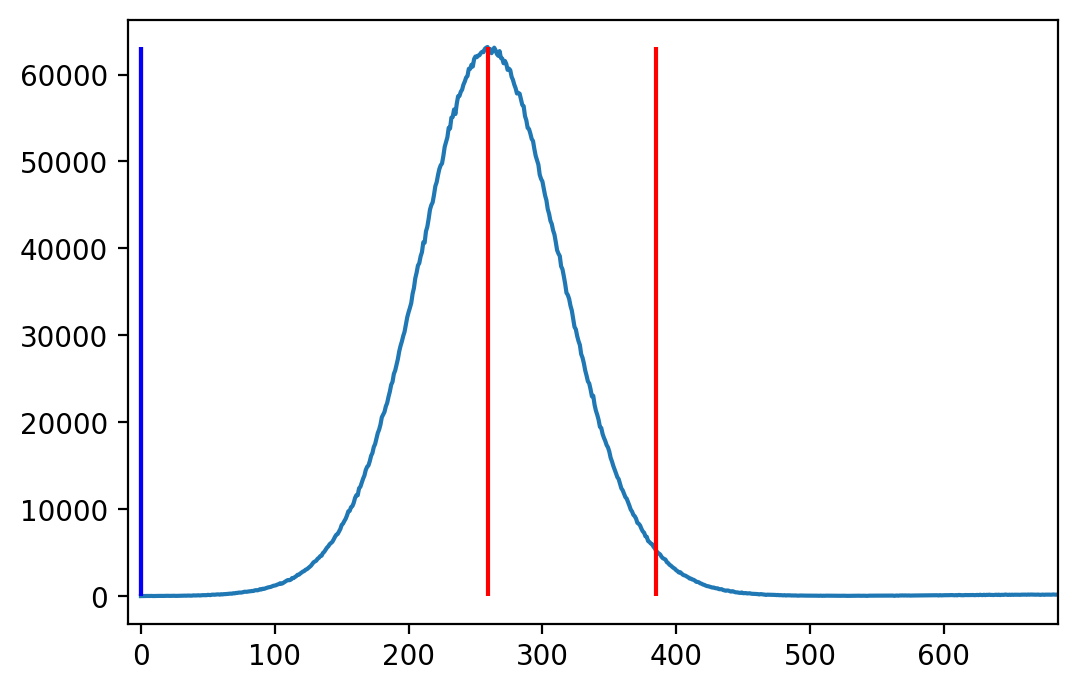

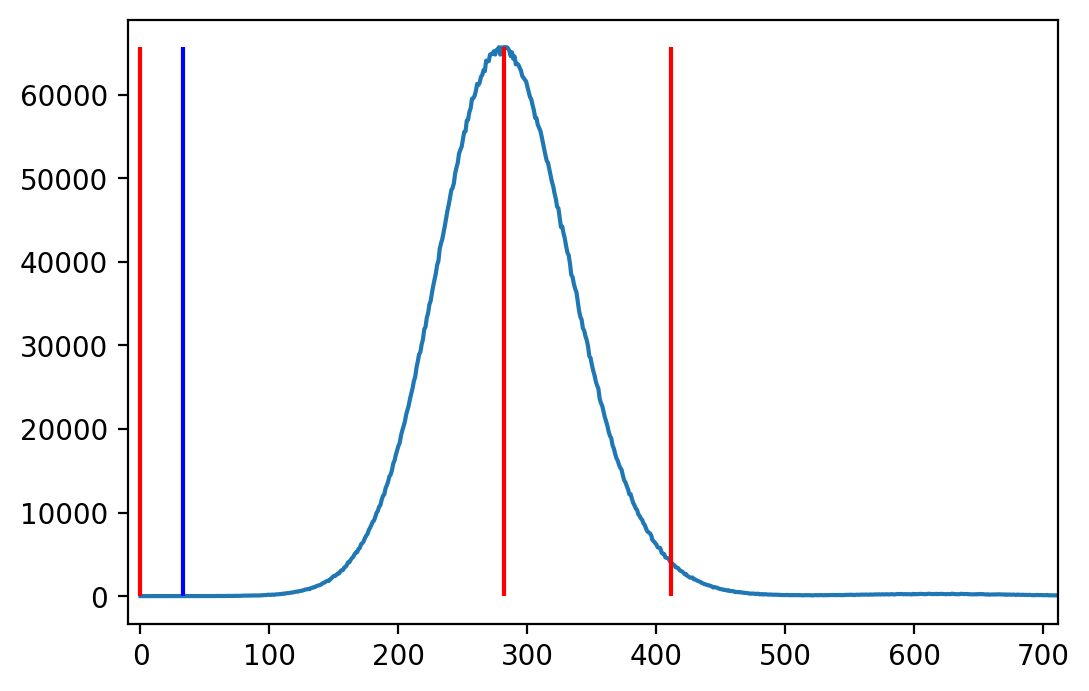

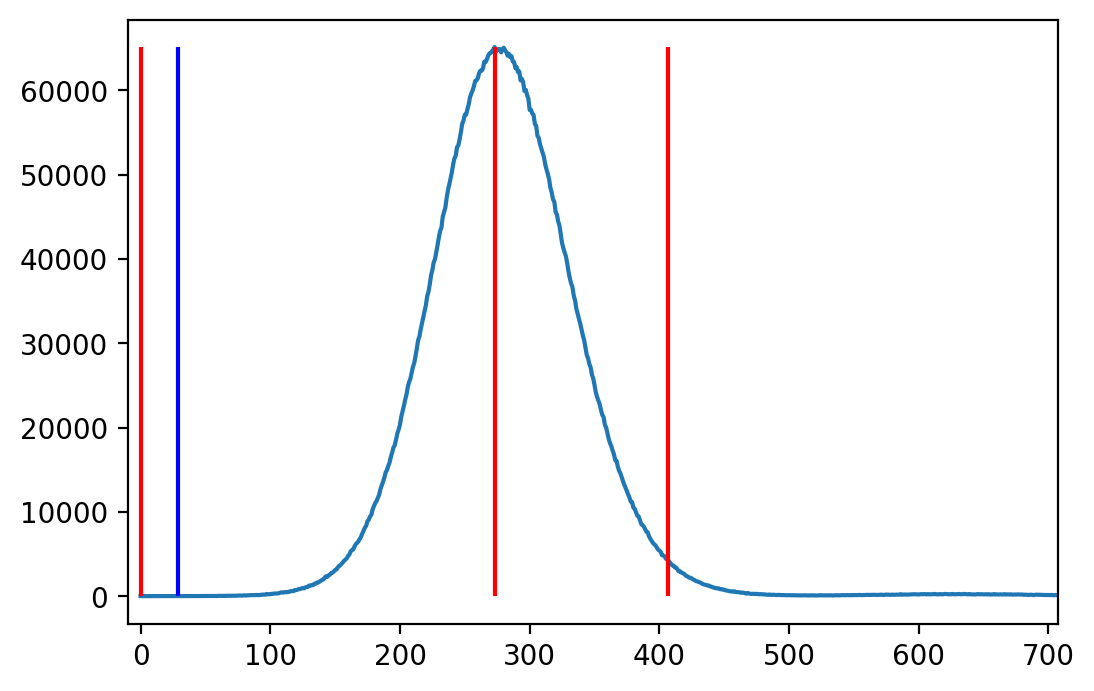

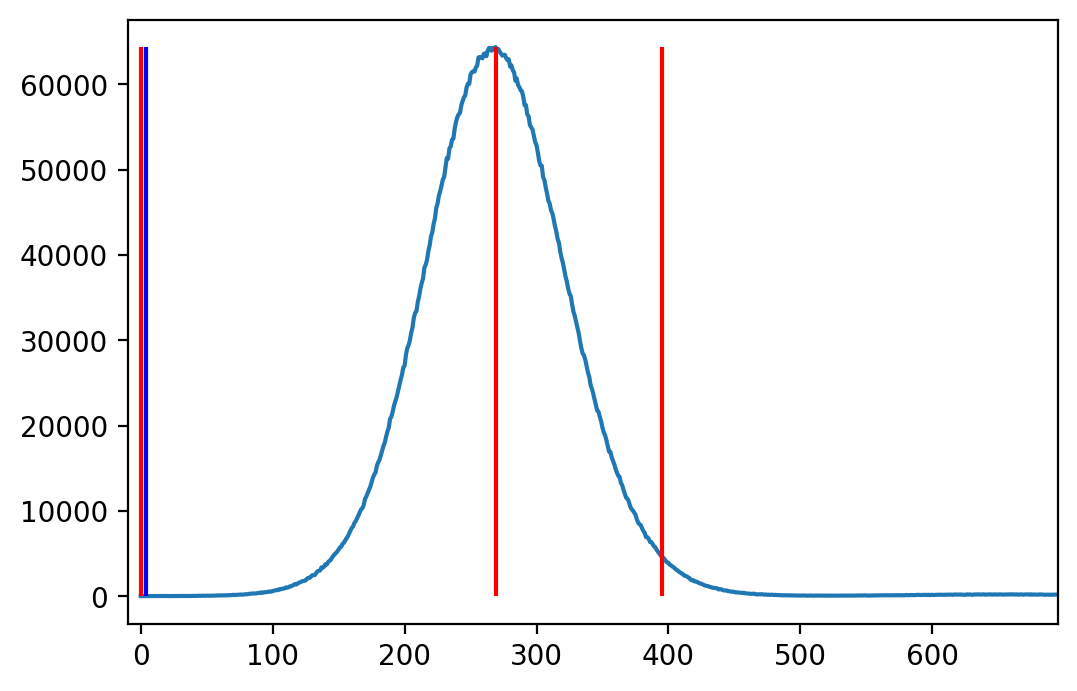

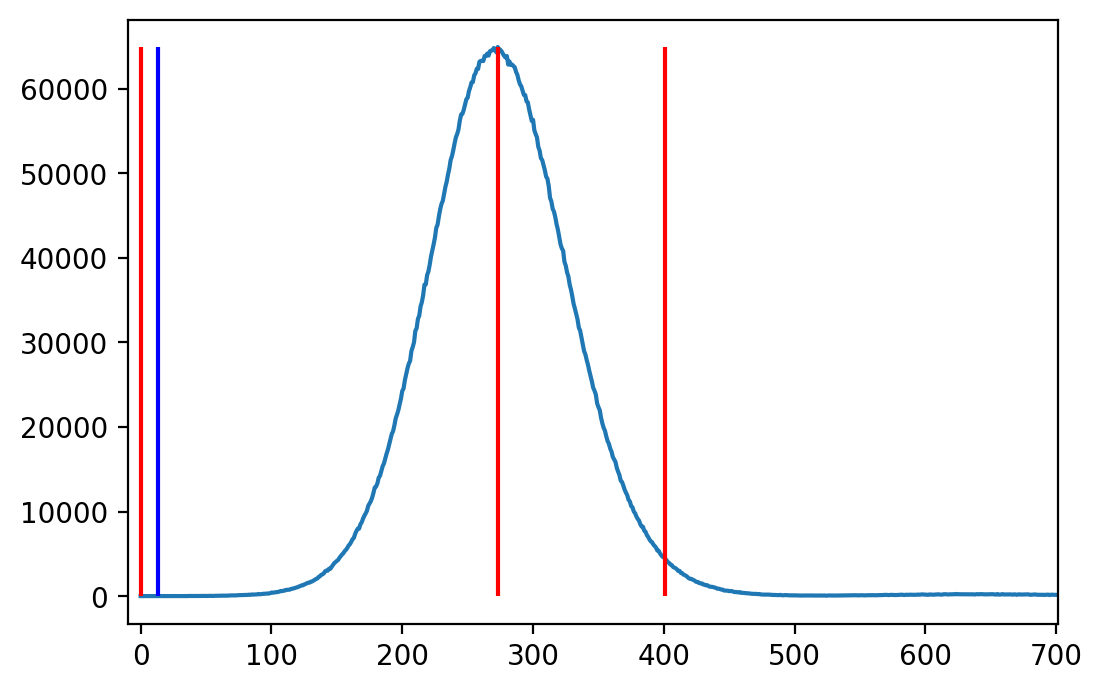

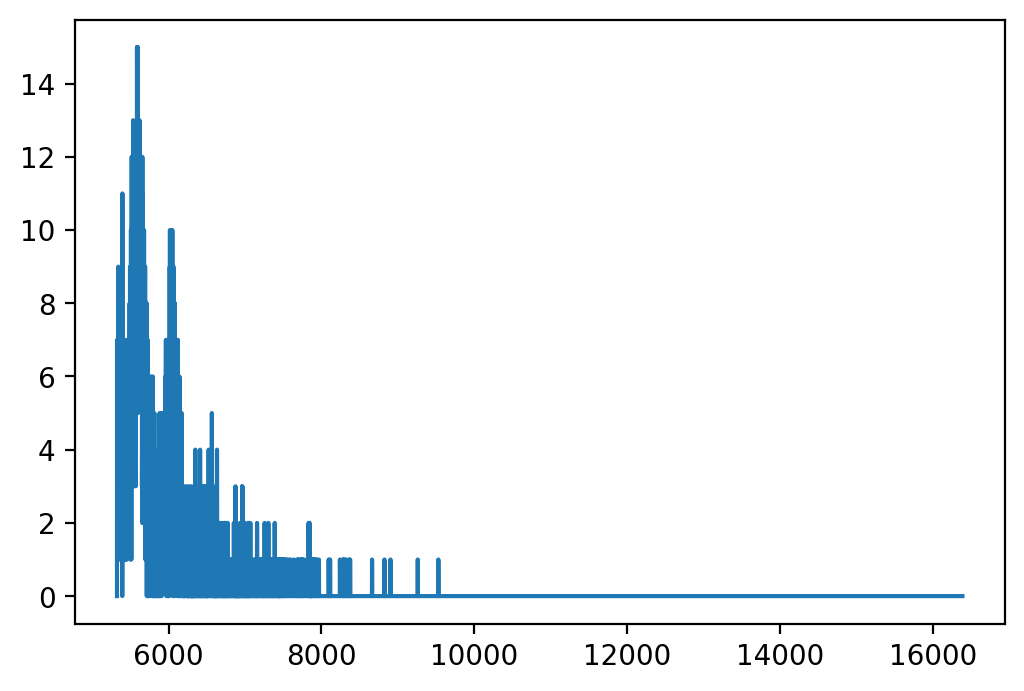

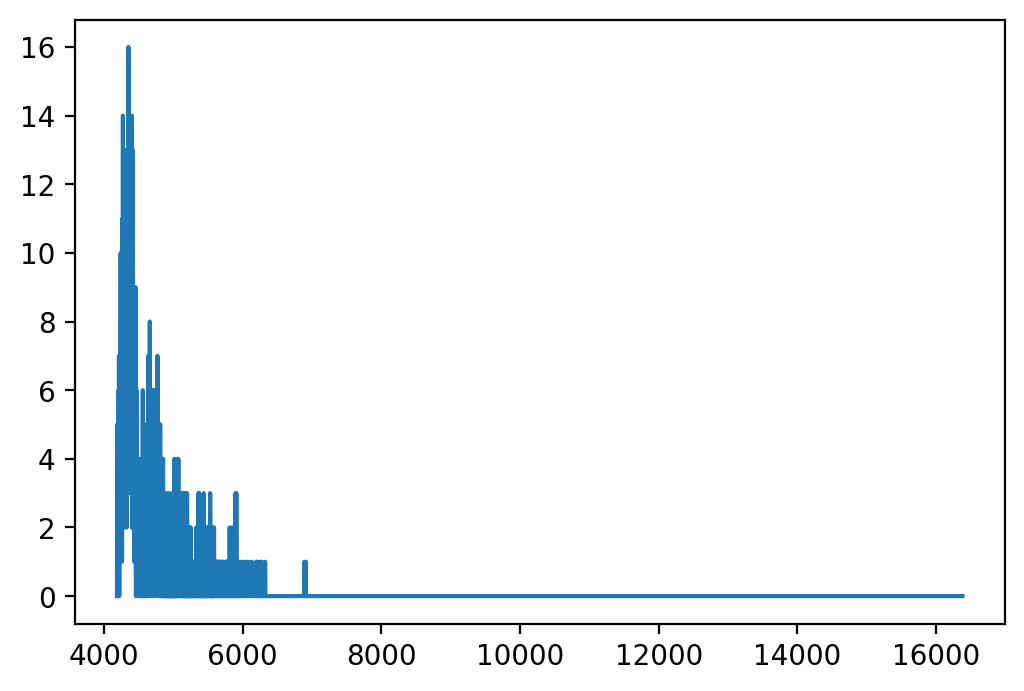

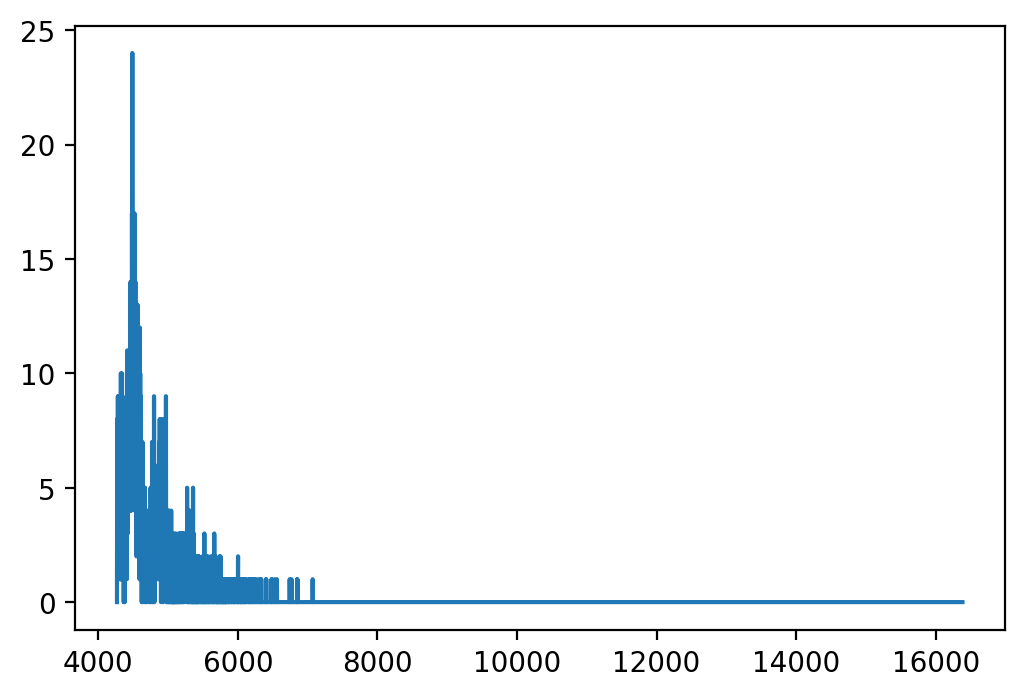

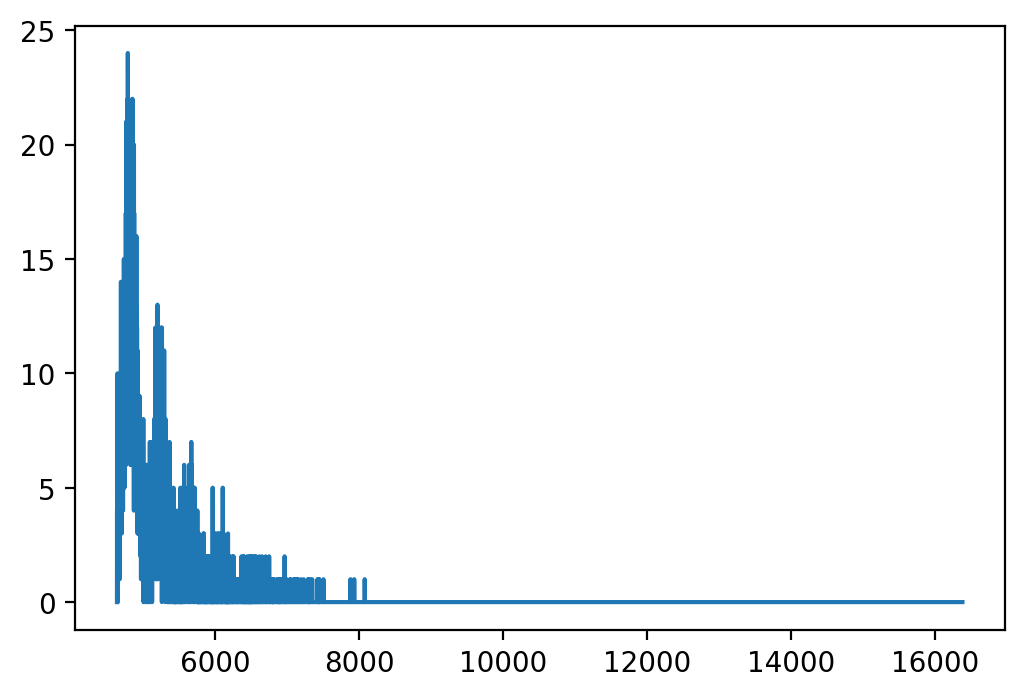

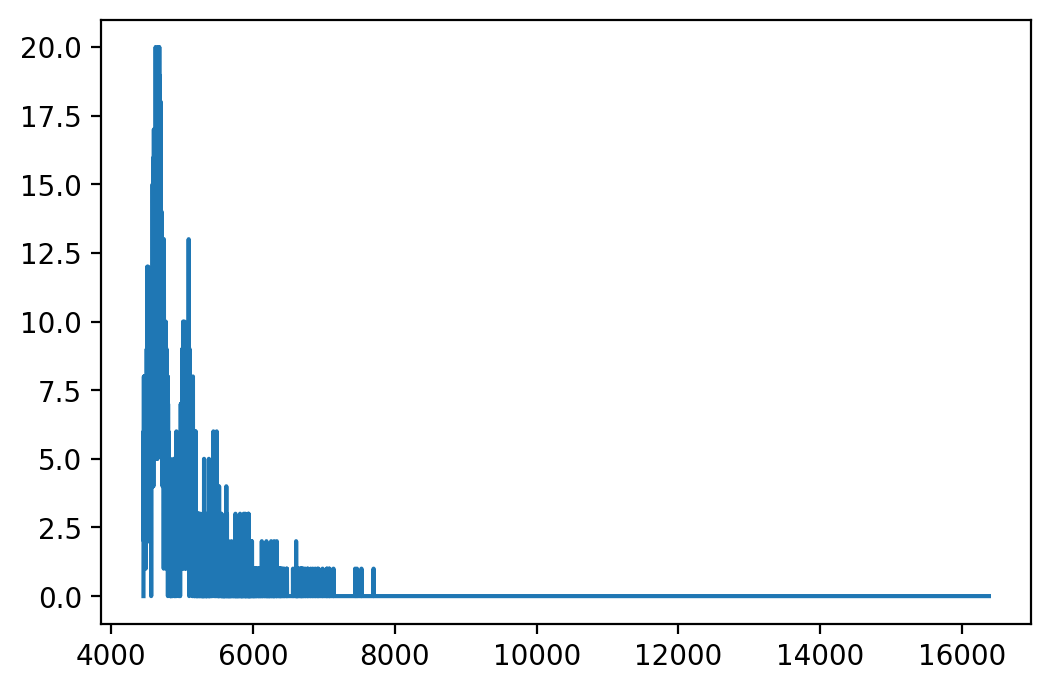

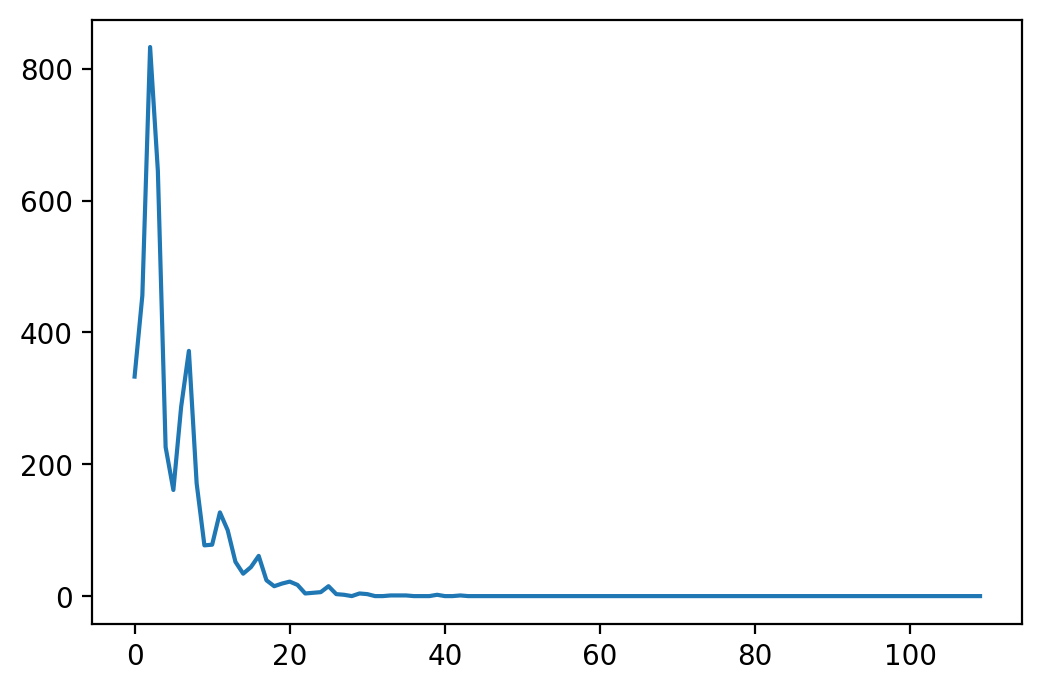

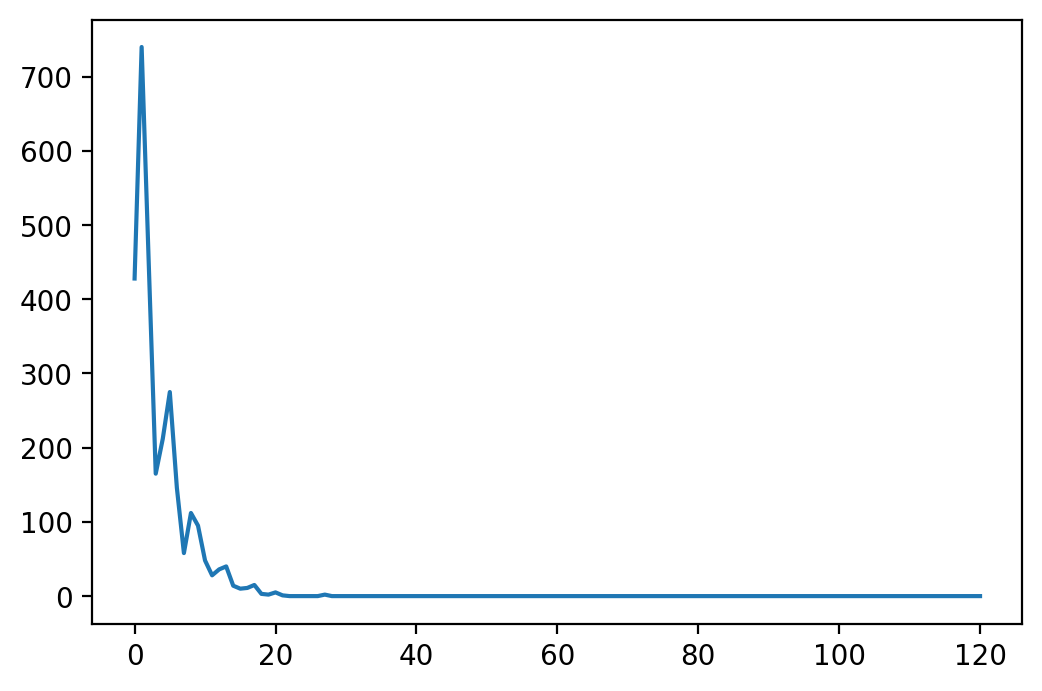

IntProgress(value=0, bar_style='info', description='Loading MCA perms...', layout=Layout(width='100%'), max=10…

IntProgress(value=0, bar_style='info', description='Loading MCA perms...', layout=Layout(width='100%'), max=10…

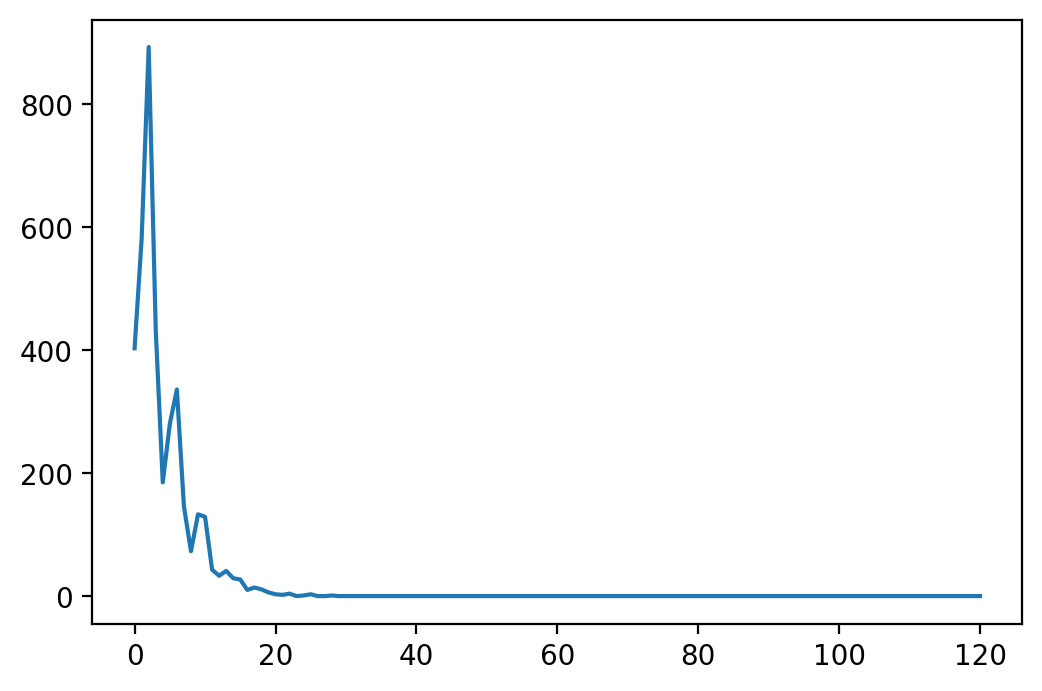

IntProgress(value=0, bar_style='info', description='Loading MCA perms...', layout=Layout(width='100%'), max=10…

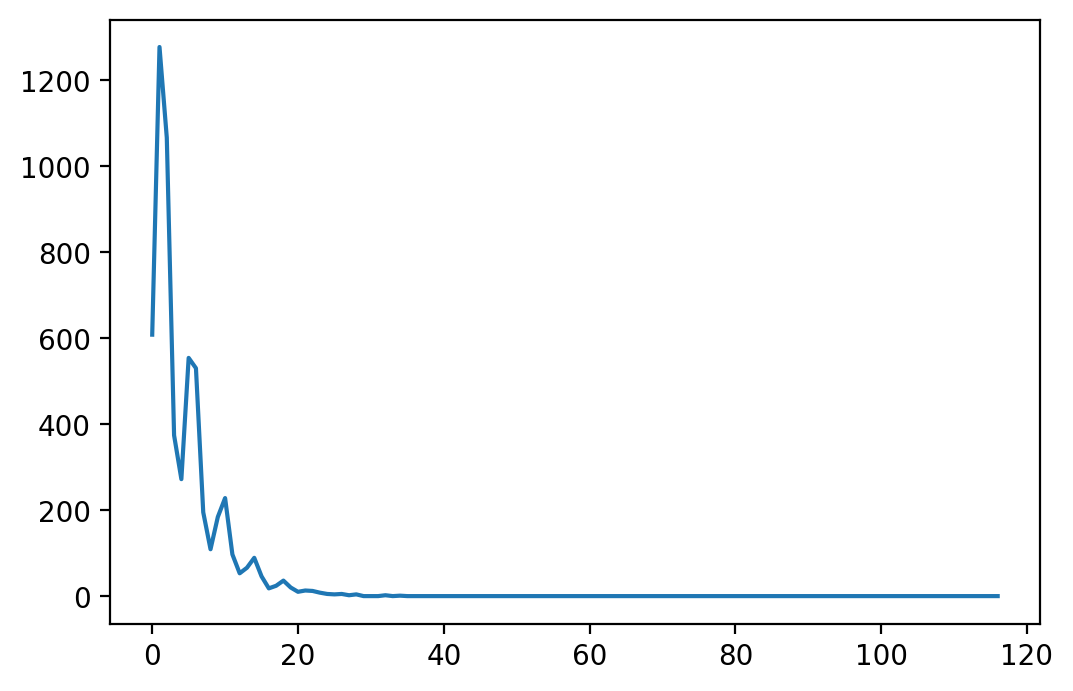

IntProgress(value=0, bar_style='info', description='Loading MCA perms...', layout=Layout(width='100%'), max=10…

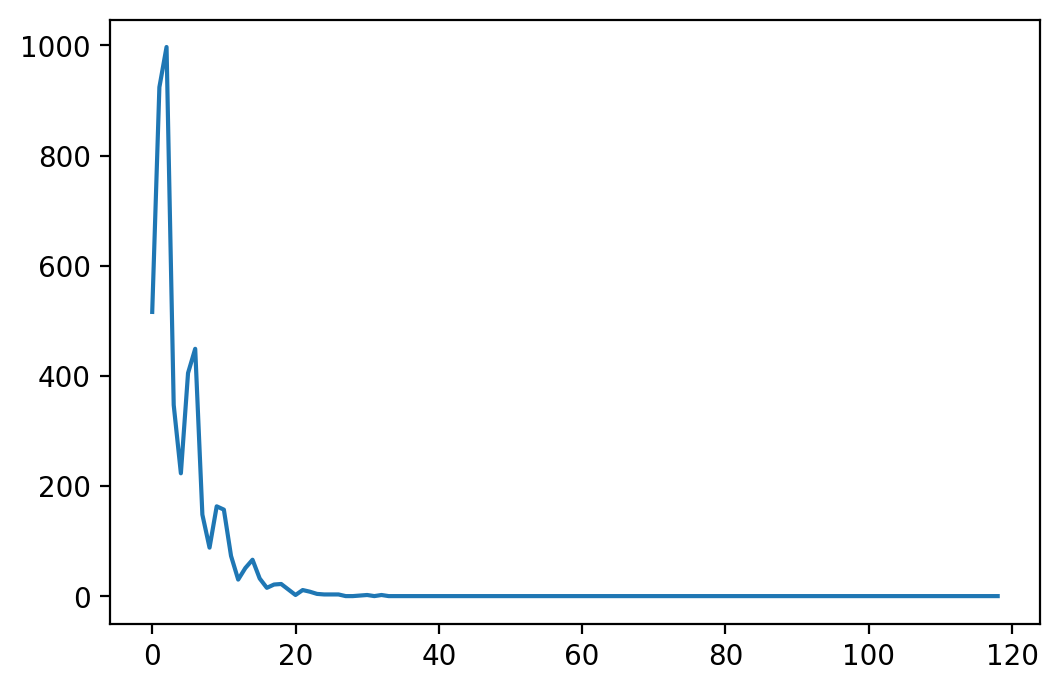

IntProgress(value=0, bar_style='info', description='Loading MCA perms...', layout=Layout(width='100%'), max=10…

{}
{}
{}
{}
{}
<DictProxy object, typeid 'dict' at 0x2b81dfa783a0; '__str__()' failed>


In [160]:
Bolt = Runner().forrest()
print(Bolt)

In [161]:
print(Bolt.keys())
"""frequencies = {}

for key in Bolt.keys():
    voltage = float(str(key).split('@')[0])
    freq = float(str(key).split('@')[1])
    gain, error = Bolt[key]

    if not freq in list(frequencies.keys()): frequencies[freq] = ([],[],[])

    frequencies[freq][0].append(voltage)
    frequencies[freq][1].append(gain)
    frequencies[freq][2].append(error)"""

BrokenPipeError: [Errno 32] Broken pipe

In [162]:
"""for f in frequencies.keys():
    voltages = frequencies[f][0]
    gains = frequencies[f][1]
    errors = frequencies[f][2]
    plt.scatter(voltages,gains)
    plt.show()"""

'for f in frequencies.keys():\n    voltages = frequencies[f][0]\n    gains = frequencies[f][1]\n    errors = frequencies[f][2]\n    plt.scatter(voltages,gains)\n    plt.show()'

In [163]:
mpl.rcParams['figure.dpi']= 200

files = glob.glob('/home/tb829/*@*.txt')

frequencies = {}

for f in files:
    if not 'backup' in f:
        filename = os.path.split(f)[1]
        voltage = float(filename.split('@')[0])
        frequency = float(filename.split('@')[1].split('.')[0])
        
        with open(f,'r') as opened:
            lines = opened.read().split(')')
            for line in lines:
                if len(line) == 0: continue
                key = line.split(':(')[0]
                value = line.split(':(')[1]
                voltage = float(key.split('@')[0])
                frequency = float(key.split('@')[1].split('.txt')[0])
                if frequency == 0.00:
                    print(filename)
                    print(line)
                gain = float(value.split(',')[0])
                error = float(value.split(',')[1])
                if not frequency in list(frequencies.keys()): frequencies[frequency] = []
                frequencies[frequency].append((voltage, (gain,error)))

                #plt.scatter([voltage],[gain],30,c='red',marker='*')
    #plt.clf()
                
frequencies_un = np.unique(list(frequencies.keys()))
#with open(f'{voltage}@{frequency}.txt','w') as f:

0.50kHz ->  192.42353 ± 0.00225      (slateblue)
0.60kHz ->  193.58632 ± 0.00241      (green)
0.70kHz ->  196.10608 ± 0.00202      (brown)
0.80kHz ->  169.99816 ± 0.00397      (yellow)
0.90kHz ->  170.34314 ± 0.00441      (red)
1.00kHz ->  169.90458 ± 0.00151      (blue)
2.00kHz ->  143.64509 ± 0.00248      (navy)
5.00kHz ->  104.93988 ± 0.00423      (magenta)
7.00kHz ->  89.61547 ± 0.00999      (orange)
10.00kHz ->  75.66535 ± 0.00462      (purple)


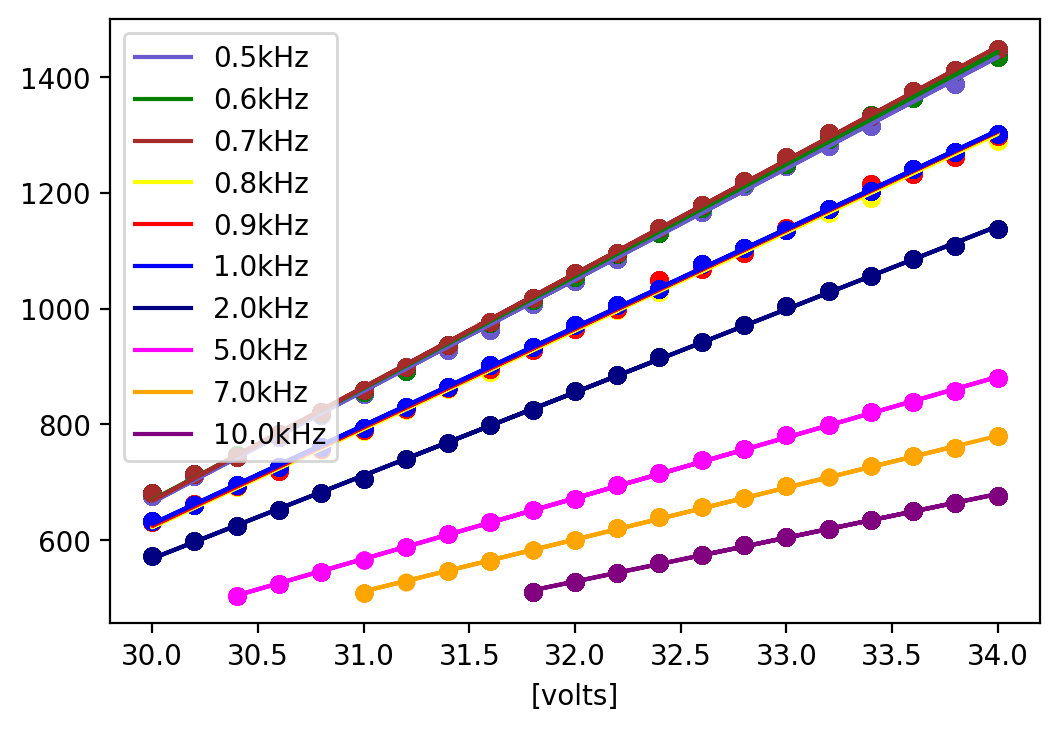

In [164]:
colors = ['slateblue', 'green', 'brown', 'yellow', 'red', 'blue', 'navy','magenta','orange','purple']
def line(x,a,b): return a*(x-b)
plt.figure(facecolor='white')
for ii, freq in enumerate(frequencies_un):
    values = frequencies[freq]
    color = colors[ii]
    voltages = []
    gains = []
    errors = []
    for value in values:
        voltage, data_val = value
        gain, error = data_val
        if freq == 10.0 and voltage < 31.8: continue
        if freq == 7.0 and voltage < 31.0: continue
        if freq == 5.0 and voltage < 30.4: continue
        voltages.append(voltage)
        gains.append(gain)
        errors.append(error)
    
    plt.scatter(voltages,gains,30,c=color,marker='o')
    popt,pcov = curve_fit(line,voltages,gains,maxfev=1000000)
    plt.plot(voltages,line(voltages,*popt),color=color,label=str(freq)+'kHz')
    print(f'{freq:.02f}kHz ->  {popt[0]:.5f} ± {np.sqrt(np.diag(pcov))[1]:.5f}      ({color})')
plt.legend(loc='upper left')
plt.xlabel('[volts]')
plt.show()